In [1]:
import sys
#sys.path.append('/Users/z5288866/.venvs/pnd_env/lib/python3.9/site-packages')

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio

# Configurations
canvas_size = 100
scale = 5  # Display scaling (for easier drawing)
drawing = False
path_points = []

# Create white canvas
img = np.ones((canvas_size * scale, canvas_size * scale), dtype=np.uint8) * 255
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

def draw(event, x, y, flags, param):
    global drawing, path_points, img_color

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        path_points.append((x, y))
        cv2.circle(img_color, (x, y), 1, (0, 0, 255), -1)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            path_points.append((x, y))
            cv2.line(img_color, path_points[-2], path_points[-1], (0, 0, 255), 1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

cv2.namedWindow("Draw Path")
cv2.setMouseCallback("Draw Path", draw)

print("Draw by dragging the mouse like in MS Paint. Press ESC when finished.")

while True:
    cv2.imshow("Draw Path", img_color)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC
        break

cv2.destroyAllWindows()

# Downscale to 100x100 coordinates
path_array = np.array([(x / scale, y / scale) for (x, y) in path_points], dtype=np.float32)
np.save("path.npy", path_array)
print(f"Saved path with {len(path_array)} points to 'path.npy'")


Draw by dragging the mouse like in MS Paint. Press ESC when finished.
Saved path with 575 points to 'path.npy'


In [11]:
import numpy as np
path = np.load("path.npy")
print(path.shape)  # (N, 2)

(575, 2)


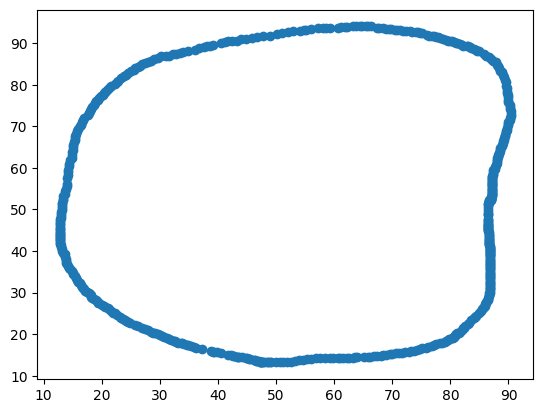

In [12]:
plt.scatter(path[:,0], path[:,1])

In [16]:
class CustomTrackEnv:
    def __init__(self, path_file='path.npy', track_radius=0.2):
        self.centerline = np.load(path_file)
        self.centerline = self.centerline - np.mean(self.centerline, axis=0)
        self.centerline = self.centerline / np.max(np.abs(self.centerline))  # scale to [-1, 1]
        self.track_radius = track_radius
        self.center = np.mean(self.centerline, axis=0)  # center of mass of the track
        self.reset()

    def reset(self):
        self.car_pos = np.copy(self.centerline[0])
        self.car_vel = 0.1
        direction = self.centerline[1] - self.centerline[0]
        self.car_angle = np.pi / 2  # Face upward
        self.done = False
        self.passed_checkpoints = np.zeros(len(self.centerline), dtype=bool)
        return self.get_observation()

    def is_on_track(self, point):
        return np.any(np.linalg.norm(self.centerline - point, axis=1) < self.track_radius)

    def get_observation(self):
        angles = [-np.pi/4, -np.pi/9, 0, np.pi/9, np.pi/4]
        max_dist = 3.0
        distances = []
        for offset in angles:
            direction = np.array([
                np.cos(self.car_angle + offset),
                np.sin(self.car_angle + offset)
            ])
            for d in np.linspace(0, max_dist, 30):
                probe = self.car_pos + d * direction
                if not self.is_on_track(probe):
                    distances.append(d)
                    break
            else:
                distances.append(max_dist)
        return np.array(distances)

    def step(self, action):
        steer, throttle = np.clip(action, -1, 1)
        self.car_angle += steer * 0.1
        self.car_vel = np.clip(self.car_vel + throttle * 0.01, 0.05, 0.2)
        forward = np.array([np.cos(self.car_angle), np.sin(self.car_angle)])
        self.car_pos += self.car_vel * forward

        if not self.is_on_track(self.car_pos):
            self.done = True
            return self.get_observation(), -10, self.done

        # Directional reward
        next_idx = self._closest_checkpoint_index()
        dir_to_next = self.centerline[next_idx] - self.car_pos
        dir_to_next /= np.linalg.norm(dir_to_next)
        directional_alignment = np.dot(dir_to_next, forward)

        # Track progress
        for i, point in enumerate(self.centerline):
            if not self.passed_checkpoints[i] and np.linalg.norm(self.car_pos - point) < self.track_radius / 2:
                self.passed_checkpoints[i] = True

        # CCW reward via center of mass
        r = self.car_pos - self.center
        cross_z = r[0] * forward[1] - r[1] * forward[0]
        rotation_reward = np.sign(cross_z) * 0.2  # reward +0.2 for CCW, -0.2 for CW

        obs = self.get_observation()
        progress_bonus = np.sum(self.passed_checkpoints) / len(self.centerline)
        reward = self.car_vel + 0.1 * directional_alignment + 2.0 * progress_bonus + rotation_reward
        return obs, reward, self.done

    def _closest_checkpoint_index(self):
        distances = np.linalg.norm(self.centerline - self.car_pos, axis=1)
        return np.argmin(distances)

    def render(self, title=None):
        fig, ax = plt.subplots()
        ax.plot(self.centerline[:, 0], self.centerline[:, 1], 'k--', label='Centerline')
        for p in self.centerline:
            circle = plt.Circle(p, self.track_radius, color='lightgray', alpha=0.3)
            ax.add_patch(circle)
        ax.plot(self.car_pos[0], self.car_pos[1], 'ro', label='Car')

        # Draw center of mass
        ax.plot(self.center[0], self.center[1], 'gx', label='Center of Mass')

        # Sensor rays
        angles = [-np.pi/4, -np.pi/9, 0, np.pi/9, np.pi/4]
        obs = self.get_observation()
        for i, offset in enumerate(angles):
            d = obs[i]
            dir = np.array([np.cos(self.car_angle + offset), np.sin(self.car_angle + offset)])
            end = self.car_pos + dir * d
            ax.plot([self.car_pos[0], end[0]], [self.car_pos[1], end[1]], color='cyan')

        if title:
            ax.set_title(title)

        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return image

def simple_policy(obs, weights):
    return np.tanh(np.dot(weights, obs))

def mutate(weights, mutation_rate=0.05):
    return weights + mutation_rate * np.random.randn(*weights.shape)

if __name__ == '__main__':
    generations = 15
    population_size = 20
    input_size = 5
    mutation_rate = 0.2
    frames = []

    agents = [np.random.randn(2, input_size) for _ in range(population_size)]

    for gen in range(generations):
        scores = []
        for i, agent in enumerate(agents):
            env = CustomTrackEnv()
            obs = env.reset()
            total_reward = 0
            steps = 0
            while not env.done and steps < 200:
                action = simple_policy(obs, agent)
                obs, reward, done = env.step(action)
                if i == 0:
                    frames.append(env.render(title=f"Generation {gen + 1}"))
                total_reward += reward
                steps += 1
            scores.append(total_reward)

        best_indices = np.argsort(scores)[-5:]
        best_agents = [agents[i] for i in best_indices]
        agents = []
        for parent in best_agents:
            for _ in range(population_size // len(best_agents)):
                agents.append(mutate(parent, mutation_rate))
        print(f"Generation {gen + 1}, Best Score: {scores[best_indices[-1]]:.2f}")
        if scores[best_indices[-1]] > 2000:
            print('we got beyond 200! finishing to learn now')
            break

    # imageio.mimsave('race_learning_custom_direction.gif', frames, duration=1/30)
    imageio.mimsave("race_learning_custom_direction.mp4", frames, fps=30, codec='libx264')



Generation 1, Best Score: -4.51
Generation 2, Best Score: -3.00
Generation 3, Best Score: -1.52
Generation 4, Best Score: 0.92
Generation 5, Best Score: 3.56
Generation 6, Best Score: 20.38
Generation 7, Best Score: 249.35
Generation 8, Best Score: 244.41
Generation 9, Best Score: 236.91
Generation 10, Best Score: 292.80
Generation 11, Best Score: 309.53
Generation 12, Best Score: 322.29
Generation 13, Best Score: 338.76
Generation 14, Best Score: 341.71
Generation 15, Best Score: 342.75
